In [2]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

result = np.load('../bayes_implicit_solvent/data/smirnoff_nb_types_nelder-mead_freesolv_n_config=25_gaussian_ll_traj.npz')

In [3]:
traj = result['traj']

In [4]:
loss_traj = result['loss_traj']

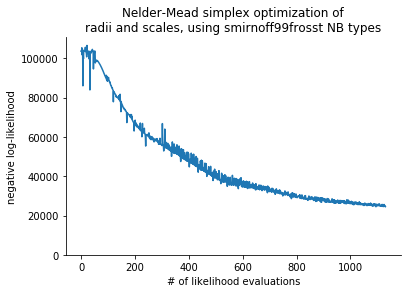

In [6]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(loss_traj)
plt.ylim(0,)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('negative log-likelihood')

title = 'Nelder-Mead simplex optimization of\nradii and scales, using smirnoff99frosst NB types'
plt.title(title)

plt.savefig('nelder_mead_plots_smirnoff/log-likelihood.png', dpi=300)

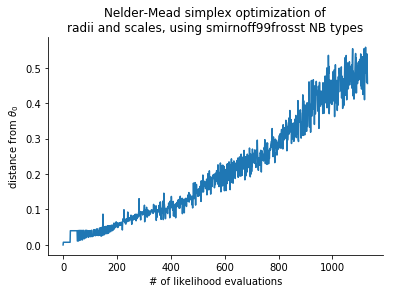

In [7]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(np.linalg.norm(traj - traj[0], axis=1))
plt.xlabel('# of likelihood evaluations')
plt.ylabel(r'distance from $\theta_0$')
plt.title(title)

plt.savefig('nelder_mead_plots_smirnoff/distance-from-start.png', dpi=300)

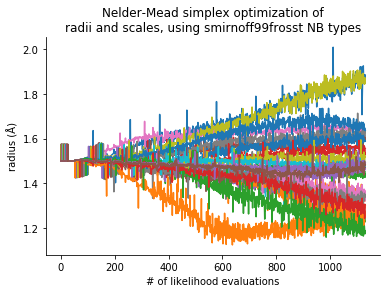

In [8]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, :n] * 10)

plt.xlabel('# of likelihood evaluations')
plt.ylabel('radius (Å)')

plt.title(title)

plt.savefig('nelder_mead_plots_smirnoff/radii.png', dpi=300)

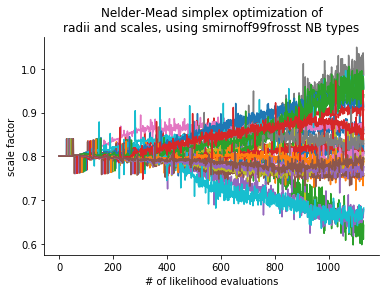

In [9]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, n:])

plt.xlabel('# of likelihood evaluations')
plt.ylabel('scale factor')

plt.title(title)

plt.savefig('nelder_mead_plots_smirnoff/scales.png', dpi=300)

In [10]:
min(loss_traj)

24482.017110477245

In [11]:
from bayes_implicit_solvent.continuous_parameter_experiments import smirnoff_types
from bayes_implicit_solvent.continuous_parameter_experiments.smirnoff_types import extract_cid_key
from bayes_implicit_solvent.freesolv import cid_to_smiles
from bayes_implicit_solvent.molecule import Molecule

In [12]:
from pkg_resources import resource_filename
from glob import glob
path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                           'vacuum_samples/vacuum_samples_*.npy')
paths_to_samples = glob(path_to_vacuum_samples)
np.random.seed(0)
np.random.shuffle(paths_to_samples)
paths_to_samples = paths_to_samples#
train_paths_to_samples = paths_to_samples[::2]
test_paths_to_samples = paths_to_samples[1::2]

print('number of molecules being considered: {}'.format(len(paths_to_samples)))

cids = list(map(extract_cid_key, paths_to_samples))
train_cids = list(map(extract_cid_key, train_paths_to_samples))
test_cids = list(map(extract_cid_key, test_paths_to_samples))
print('first few CIDs', cids[:5])

mols = []

n_configuration_samples = 50

for path in paths_to_samples:
    cid = extract_cid_key(path)
    smiles = cid_to_smiles[cid]
    vacuum_samples = smirnoff_types.sample_path_to_unitted_snapshots(path)
    thinning = int(len(vacuum_samples) / n_configuration_samples)
    mol = Molecule(smiles, vacuum_samples=vacuum_samples[::thinning])
    mols.append(mol)
    
from bayes_implicit_solvent.continuous_parameter_experiments.smirnoff_types import initial_model

type_slices = [initial_model.apply_to_molecule(mol.mol) for mol in mols]

def construct_arrays(theta):
    n = int(len(theta) / 2)
    radii, scales = theta[:n], theta[n:]

    parameterized_list = []
    for i in range(len(mols)):
        parameterized_list.append((radii[type_slices[i]], scales[type_slices[i]]))
    return parameterized_list

number of molecules being considered: 642
first few CIDs ['mobley_3187514', 'mobley_1363784', 'mobley_900088', 'mobley_9913368', 'mobley_766666']


In [13]:
from simtk import unit
from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

def make_predictions(theta):
    predictions = np.zeros(len(mols))
    parameterized_list = construct_arrays(theta)
    for i, mol in enumerate(mols):
        radii, scale_factors = parameterized_list[i]
        predictions[i] = mol.predict_solvation_free_energy(radii, scale_factors)[0]
    return unreduce(predictions)

In [14]:
%%time
initial_predictions = make_predictions(traj[0])

CPU times: user 3.62 s, sys: 20.4 ms, total: 3.64 s
Wall time: 3.66 s


In [15]:
%%time
optimized_predictions = make_predictions(traj[-1])

CPU times: user 3.56 s, sys: 17.8 ms, total: 3.58 s
Wall time: 3.62 s


In [16]:
mol = mols[0]
mol.experimental_value

-9.333559357658267

In [17]:
experimental_values = np.zeros(len(mols))
for i in range(len(mols)):
    experimental_values[i] = unreduce(mols[i].experimental_value)

In [18]:
sum((experimental_values >= -15) * (experimental_values <= 5))

631

In [19]:
mask = (experimental_values >= -15) * (experimental_values <= 5)
mask[:5]

array([ True,  True,  True,  True,  True])

In [20]:
len(experimental_values)

642

In [21]:
max(experimental_values)

3.4300000000000006

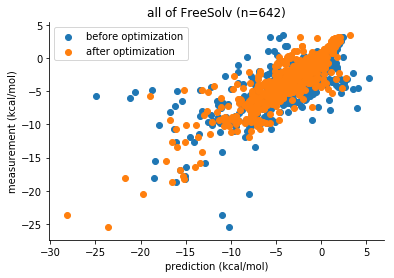

In [22]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions, experimental_values, label='before optimization')
plt.scatter(optimized_predictions, experimental_values, label='after optimization')
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

all_freesolv_descr = 'all of FreeSolv (n={})'.format(len(experimental_values))
plt.title(all_freesolv_descr)


plt.savefig('nelder_mead_plots_smirnoff/scatter-all-freesolv.png', dpi=300)

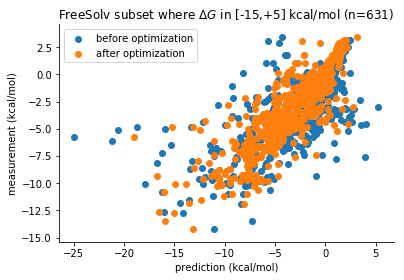

In [23]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions[mask], experimental_values[mask], label='before optimization')
plt.scatter(optimized_predictions[mask], experimental_values[mask], label='after optimization')

freesolv_subset_descr = 'FreeSolv subset where $\Delta G$ in [-15,+5] kcal/mol (n={})'.format(sum(mask))
plt.title(freesolv_subset_descr)
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

plt.savefig('nelder_mead_plots_smirnoff/scatter-freesolv-subset.png', dpi=300)

In [24]:
np.sqrt(np.mean((initial_predictions - experimental_values)**2)), np.sqrt(np.mean((optimized_predictions - experimental_values)**2))

(3.1212698603792957, 2.09882163229339)

In [25]:
np.sqrt(np.mean((initial_predictions[mask] - experimental_values[mask])**2)), np.sqrt(np.mean((optimized_predictions[mask] - experimental_values[mask])**2))

(2.9957118251586596, 2.089232019312353)

In [26]:
from tqdm import tqdm
thinning = 10

prediction_traj = []

for snapshot in tqdm(traj[::thinning]):
    prediction_traj.append(make_predictions(snapshot))

100%|██████████| 114/114 [06:54<00:00,  3.53s/it]


In [27]:
prediction_traj = np.array(prediction_traj)
prediction_traj.shape

(114, 642)

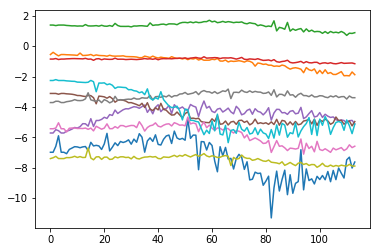

In [28]:
for _ in range(10):
    i = np.random.randint(len(mols))
    plt.plot(prediction_traj[:,i])

No handles with labels found to put in legend.


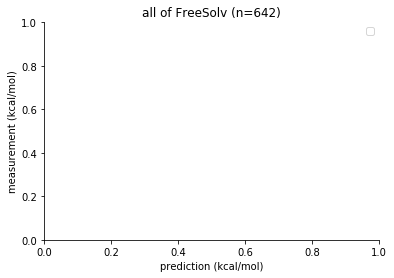

In [29]:
ax = plt.subplot(111)
remove_top_right_spines(ax)



plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

all_freesolv_descr = 'all of FreeSolv (n={})'.format(len(experimental_values))
plt.title(all_freesolv_descr)


plt.savefig('nelder_mead_plots_smirnoff/scatter-all-freesolv.png', dpi=300)

In [30]:
x = np.arange(len(traj))[::thinning]

In [31]:
rmses = []
masked_rmses = []
for predictions in prediction_traj:
    rmses.append(np.sqrt(np.mean((predictions - experimental_values)**2)))
    masked_rmses.append(np.sqrt(np.mean((predictions[mask] - experimental_values[mask])**2)))

In [32]:
min(rmses), min(masked_rmses)

(2.0767608270208466, 2.057159384292823)

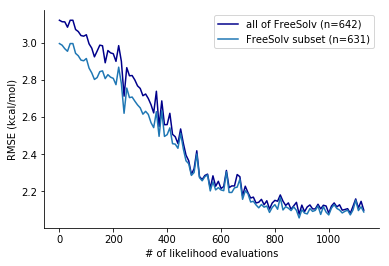

In [33]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(x, rmses, color='darkblue', label=all_freesolv_descr)
plt.plot(x, masked_rmses, label='FreeSolv subset (n={})'.format(sum(mask)))
#plt.ylim(0,)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('RMSE (kcal/mol)')
plt.legend()

plt.savefig('nelder_mead_plots_smirnoff/rmse-trace.png', dpi=300)

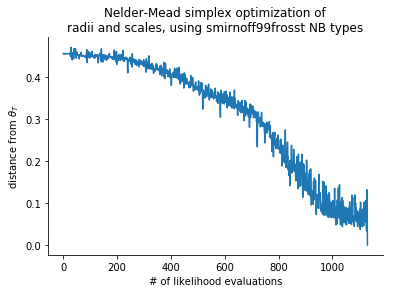

In [34]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(np.linalg.norm(traj - traj[-1], axis=1))
plt.xlabel('# of likelihood evaluations')
plt.ylabel(r'distance from $\theta_T$')
plt.title(title)

plt.savefig('nelder_mead_plots_smirnoff/distance-from-end.png', dpi=300)

In [36]:
initial_model.ordered_nodes

['*',
 '[#1]',
 '[#1]-[#6X3]',
 '[#6]',
 '[#7]',
 '[#8]',
 '[#9]',
 '[#15]',
 '[#16]',
 '[#17]',
 '[#35]',
 '[#53]',
 '[#1]-[#6X4]',
 '[#1]-[#6X2]',
 '[#1]-[#7]',
 '[#1]-[#8]',
 '[#1]-[#16]',
 '[#1]-[#6X3]~[#7,#8,#9,#16,#17,#35]',
 '[#6X2]',
 '[#6X4]',
 '[#8X2H0+0]',
 '[#8X2H1+0]',
 '[#1]-[#6X4]-[#7,#8,#9,#16,#17,#35]',
 '[#1]-[#6X4]~[*+1,*+2]',
 '[#1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]',
 '[#1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]']

In [38]:
initial_radii = traj[0][:n]
initial_scales = traj[0][n:]

initial_radii

array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])

In [39]:
optimized_radii = traj[-1][:n]
optimized_scales = traj[-1][n:]

In [40]:
list(zip(initial_model.ordered_nodes, initial_radii))

[('*', 0.15),
 ('[#1]', 0.15),
 ('[#1]-[#6X3]', 0.15),
 ('[#6]', 0.15),
 ('[#7]', 0.15),
 ('[#8]', 0.15),
 ('[#9]', 0.15),
 ('[#15]', 0.15),
 ('[#16]', 0.15),
 ('[#17]', 0.15),
 ('[#35]', 0.15),
 ('[#53]', 0.15),
 ('[#1]-[#6X4]', 0.15),
 ('[#1]-[#6X2]', 0.15),
 ('[#1]-[#7]', 0.15),
 ('[#1]-[#8]', 0.15),
 ('[#1]-[#16]', 0.15),
 ('[#1]-[#6X3]~[#7,#8,#9,#16,#17,#35]', 0.15),
 ('[#6X2]', 0.15),
 ('[#6X4]', 0.15),
 ('[#8X2H0+0]', 0.15),
 ('[#8X2H1+0]', 0.15),
 ('[#1]-[#6X4]-[#7,#8,#9,#16,#17,#35]', 0.15),
 ('[#1]-[#6X4]~[*+1,*+2]', 0.15),
 ('[#1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]', 0.15),
 ('[#1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]',
  0.15)]

In [41]:
list(zip(initial_model.ordered_nodes, [float('{:.3f}'.format(x)) for x in optimized_radii]))

[('*', 0.185),
 ('[#1]', 0.136),
 ('[#1]-[#6X3]', 0.125),
 ('[#6]', 0.156),
 ('[#7]', 0.135),
 ('[#8]', 0.16),
 ('[#9]', 0.164),
 ('[#15]', 0.161),
 ('[#16]', 0.185),
 ('[#17]', 0.127),
 ('[#35]', 0.159),
 ('[#53]', 0.13),
 ('[#1]-[#6X4]', 0.144),
 ('[#1]-[#6X2]', 0.154),
 ('[#1]-[#7]', 0.147),
 ('[#1]-[#8]', 0.147),
 ('[#1]-[#16]', 0.137),
 ('[#1]-[#6X3]~[#7,#8,#9,#16,#17,#35]', 0.135),
 ('[#6X2]', 0.152),
 ('[#6X4]', 0.149),
 ('[#8X2H0+0]', 0.164),
 ('[#8X2H1+0]', 0.125),
 ('[#1]-[#6X4]-[#7,#8,#9,#16,#17,#35]', 0.119),
 ('[#1]-[#6X4]~[*+1,*+2]', 0.13),
 ('[#1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]', 0.149),
 ('[#1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]',
  0.148)]

In [42]:
list(zip(initial_model.ordered_nodes, initial_scales))

[('*', 0.8),
 ('[#1]', 0.8),
 ('[#1]-[#6X3]', 0.8),
 ('[#6]', 0.8),
 ('[#7]', 0.8),
 ('[#8]', 0.8),
 ('[#9]', 0.8),
 ('[#15]', 0.8),
 ('[#16]', 0.8),
 ('[#17]', 0.8),
 ('[#35]', 0.8),
 ('[#53]', 0.8),
 ('[#1]-[#6X4]', 0.8),
 ('[#1]-[#6X2]', 0.8),
 ('[#1]-[#7]', 0.8),
 ('[#1]-[#8]', 0.8),
 ('[#1]-[#16]', 0.8),
 ('[#1]-[#6X3]~[#7,#8,#9,#16,#17,#35]', 0.8),
 ('[#6X2]', 0.8),
 ('[#6X4]', 0.8),
 ('[#8X2H0+0]', 0.8),
 ('[#8X2H1+0]', 0.8),
 ('[#1]-[#6X4]-[#7,#8,#9,#16,#17,#35]', 0.8),
 ('[#1]-[#6X4]~[*+1,*+2]', 0.8),
 ('[#1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]', 0.8),
 ('[#1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]',
  0.8)]

In [43]:
list(zip(initial_model.ordered_nodes, [float('{:.3f}'.format(x)) for x in optimized_scales]))

[('*', 0.862),
 ('[#1]', 0.756),
 ('[#1]-[#6X3]', 0.642),
 ('[#6]', 0.907),
 ('[#7]', 0.775),
 ('[#8]', 0.828),
 ('[#9]', 0.865),
 ('[#15]', 0.986),
 ('[#16]', 0.839),
 ('[#17]', 0.956),
 ('[#35]', 0.806),
 ('[#53]', 0.793),
 ('[#1]-[#6X4]', 0.953),
 ('[#1]-[#6X2]', 0.811),
 ('[#1]-[#7]', 0.678),
 ('[#1]-[#8]', 0.76),
 ('[#1]-[#16]', 0.801),
 ('[#1]-[#6X3]~[#7,#8,#9,#16,#17,#35]', 0.835),
 ('[#6X2]', 0.788),
 ('[#6X4]', 0.682),
 ('[#8X2H0+0]', 0.913),
 ('[#8X2H1+0]', 0.787),
 ('[#1]-[#6X4]-[#7,#8,#9,#16,#17,#35]', 0.941),
 ('[#1]-[#6X4]~[*+1,*+2]', 0.852),
 ('[#1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]', 0.776),
 ('[#1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]',
  0.794)]

In [46]:
result = np.load('../bayes_implicit_solvent/data/smirnoff_nb_types_initialized_nelder-mead_freesolv_n_config=25_gaussian_ll_traj.npz')

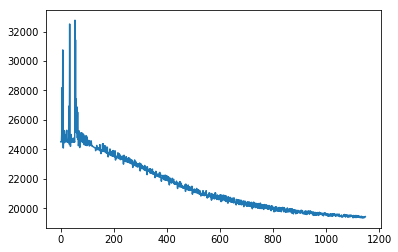

In [48]:
traj = result['traj']
loss_traj = result['loss_traj']
plt.plot(loss_traj)

In [49]:
%%time
optimized_predictions = make_predictions(traj[-1])

CPU times: user 3.82 s, sys: 131 ms, total: 3.95 s
Wall time: 3.97 s


In [50]:
np.sqrt(np.mean((optimized_predictions - experimental_values)**2))

1.885270470058542

In [51]:
np.sqrt(np.mean((optimized_predictions[mask] - experimental_values[mask])**2))

1.8698761395758134